# Pylops - local Transorms (e.g. sliding Radon)

In this notebook we will consider the case a linear or Radon transform can only be used to explain a certain 2d signal (e.g. seismic data) locally. We will thus develop a sliding window operator that takes N representations of portion of the signal in the Radon domain, converts them to the time-space domain and combines them via a sliding window approach (with tapering and overlap)

Mathematically speaking we will have an operator

$$\mathbf{SW} = \mathbf{Combine} * \mathbf{Op} * \mathbf{Slice}$$

where $\mathbf{Slice}$ extracts patches of the model, $\mathbf{Op}$ applies the same operator (e.g., forward Radon) to each patch, $\mathbf{Combine}$ recombines the outputs of $\mathbf{Op}$ (possibly with sliding windows and overlaps).

### Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from pylops import                     LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

We start by creating a data with 3 hyperbolic events

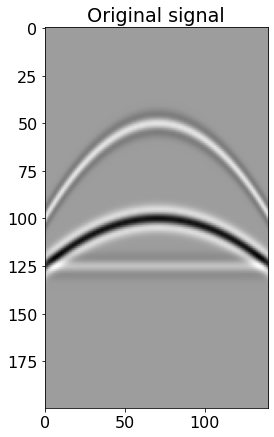

In [2]:
###### Input parameters
par = {'ox':-140, 'dx':2,    'nx':140,
       'ot':0, 'dt':0.004,'nt':200,
       'f0': 20}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
px_m = [0, 0, 0]
pxx_m = [1e-5, 5e-6, 1e-20]
amp_m   = [1., -2, 0.5]

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, data =  parabolic2d(x,t, t0_m, px_m, pxx_m,amp_m,wav)

plt.figure(figsize=(4,7))
plt.imshow(data.T, cmap='gray')
plt.title('Original signal')
plt.axis('tight');

We then subdivide the data into several patches (along the space axis) and compute the radon transform for each patch and recombine them to remake the data. Patches are adjacent here with no overlap

In [3]:
nwin = 20
nover = 0
dims = data.shape
npx=20
px = np.linspace(-5e-3, 5e-3, npx)

Op=Radon2D(t, np.linspace(-par['dx']*nwin//2, par['dx']*nwin//2, nwin), 
           px, centeredh=True, kind='linear', onthefly=False)
Slid = Sliding2D(Op, dims, dims, nwin, 0, tapertype='hanning')
dottest(Slid, par['nx']*par['nt'], par['nx']*par['nt'])

radon = Slid.H * data.flatten()
radon = radon.reshape(dims)
reconstructed_data = Slid * radon.flatten()
reconstructed_data = reconstructed_data.reshape(dims)

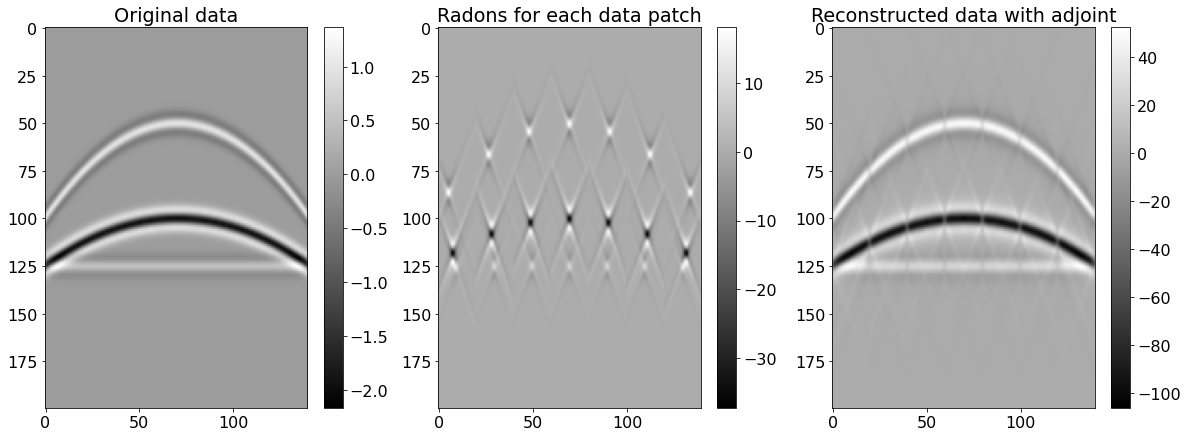

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
im = axs[0].imshow(data.T, cmap='gray')
axs[0].set_title('Original data')
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
im = axs[1].imshow(radon.T, cmap='gray')
axs[1].set_title('Radons for each data patch')
plt.colorbar(im, ax=axs[1])
axs[1].axis('tight')
im = axs[2].imshow(reconstructed_data.T, cmap='gray')
axs[2].set_title('Reconstructed data with adjoint')
plt.colorbar(im, ax=axs[2])
axs[2].axis('tight');

Let's use sliding windows now

In [5]:
nwin=36
nwins=5
nover=10
npx=61
px = np.linspace(-5e-3, 5e-3, npx)
dimsd = data.shape
dims = (nwins*npx, dimsd[1])

# sliding window radon without taper
Op = Radon2D(t, np.linspace(-par['dx']*nwin//2, par['dx']*nwin//2, nwin), px, centeredh=True,
                         kind='linear', engine='numba')
Slid = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype=None)
dottest(Slid, np.prod(data.shape), npx*nwins*par['nt'])

radon = Slid.H * data.flatten()
radon = radon.reshape(dims)

We now go back to the time-space domain but we patch the various radons with overlapping tapered windows 

In [6]:
# sliding window radon with overlap
Op = Radon2D(t, np.linspace(-par['dx']*nwin//2, par['dx']*nwin//2, nwin), px, centeredh=True,
                          kind='linear', engine='numba')
Slid1 = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine')
dottest(Slid, np.prod(data.shape), npx*nwins*par['nt'])

reconstructed_data = Slid1 * radon.flatten()
reconstructed_data = reconstructed_data.reshape(dimsd)

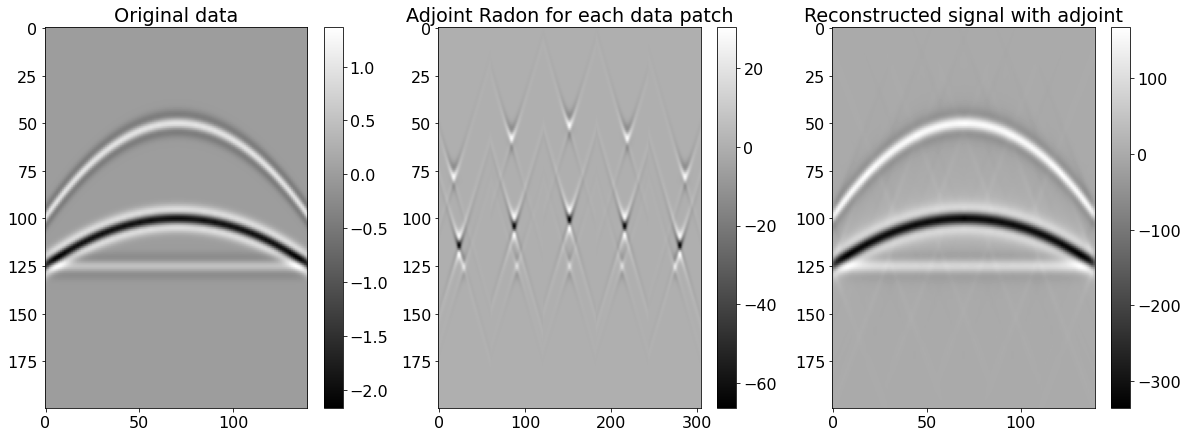

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
im = axs[0].imshow(data.T, cmap='gray')
axs[0].set_title('Original data')
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
im = axs[1].imshow(radon.T, cmap='gray')
axs[1].set_title('Adjoint Radon for each data patch')
plt.colorbar(im, ax=axs[1])
axs[1].axis('tight')
im = axs[2].imshow(reconstructed_data.T, cmap='gray')
axs[2].set_title('Reconstructed signal with adjoint')
plt.colorbar(im, ax=axs[2])
axs[2].axis('tight');

Finally we could also try to invert the operator with taper and then remake the data as forward model:

In [8]:
radoninv = LinearOperator(Slid1, explicit=False).div(data.flatten(), niter=30)
reconstructed_datainv = Slid1 * radoninv.flatten()

radoninv = radoninv.reshape(dims)
reconstructed_datainv = reconstructed_datainv.reshape(dimsd)

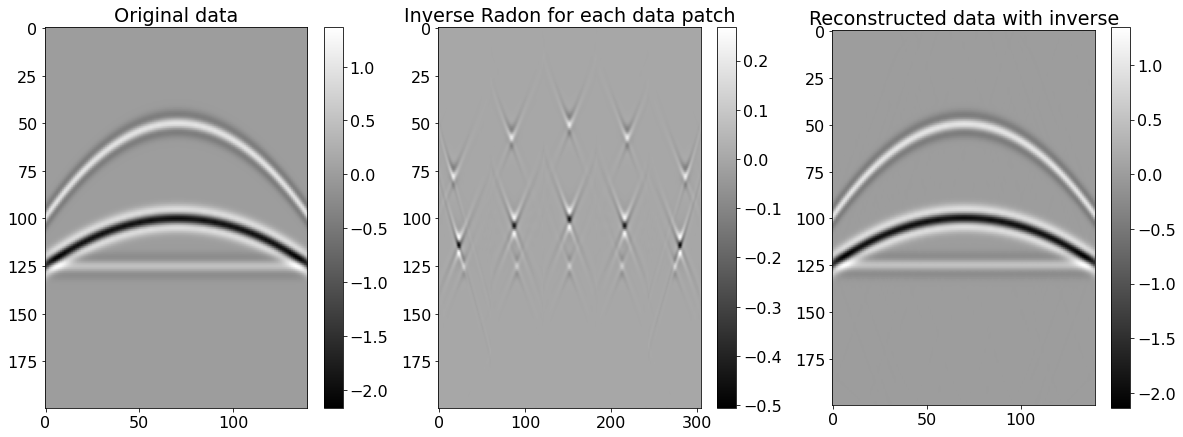

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
im = axs[0].imshow(data.T, cmap='gray')
axs[0].set_title('Original data')
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
im = axs[1].imshow(radoninv.T, cmap='gray')
axs[1].set_title('Inverse Radon for each data patch')
plt.colorbar(im, ax=axs[1])
axs[1].axis('tight')
im = axs[2].imshow(reconstructed_datainv.T, cmap='gray')
axs[2].set_title('Reconstructed data with inverse')
plt.colorbar(im, ax=axs[2])